# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Business problem: Figure out what consumers want in a used car, what makes a customer willing to purchase or pay more for a used car? How much is a customer willing to pay for certain cars?

Data Problem: Collect data on used car features and sell prices and analyze the relationship between them. Analyze and modify the data accordingly to create a model predicting car prices based on features of the used car, then evaluate and adjust models based on their accuracy, to gain an understanding of what users may be willing to pay more for.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

1. Look at the different features given in the dataset, determine whether they can be converted to numerical (quantitative) values or whether categorical values can be represented numerically.
2. Look at null values in the dataset and determine whether those can be omitted.
3. Look through unique values in each categorical feature of the dataset to determine if they can be ordinally represented or whether it is feasible to represent them via dummy variables.
4. Look at correlations between each feature and price to determine which appear to actually influence it.

#### Import libraries

In [543]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from matplotlib import rcParams
#Import libraries

#### Read in data

In [453]:
data = pd.read_csv(r'C:\Users\timmy\Downloads\data\vehicles.csv')
#Read in data as a pandas dataframe
data.info()
#Check info. See non-nulls; can tell some columns have null values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

#### Data exploration

In [306]:
data['price'].sort_values()
#Some suspiciously high prices. Decided to check this after doing some data analysis, and noticing weird results.
#Will explore other numerical values now as well.

335266             0
97994              0
97995              0
97996              0
356355             0
             ...    
37410     3009548743
91576     3024942282
257840    3024942282
318592    3736928711
356716    3736928711
Name: price, Length: 426880, dtype: int64

In [307]:
data['year'].dropna().sort_values()

96564     1900.0
123023    1900.0
398032    1900.0
154138    1900.0
269472    1900.0
           ...  
402446    2022.0
262033    2022.0
136736    2022.0
402649    2022.0
337566    2022.0
Name: year, Length: 425675, dtype: float64

In [308]:
data['odometer'].dropna().sort_values()

296426           0.0
43031            0.0
167802           0.0
246182           0.0
145742           0.0
             ...    
108797    10000000.0
110253    10000000.0
151740    10000000.0
390252    10000000.0
81327     10000000.0
Name: odometer, Length: 422480, dtype: float64

A lot of my exploration will be done in the data preparation portion.

Notably, features that correlate with price can be used for my business understanding, but this may need to be further explored after data preparation and dealing wtih categorical variables.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

1. Drop null values
2. Determine which features to use OneHotEncoding for and which to use ordinal values for (look up what the command was)
3. Determine polynomial to use for each feature and whether or not to use log. Can maybe use seasonal data split because there is an year involved... not sure if that's year of sale or year of car make. if year of sale, can maybe use that to eliminate trend and seasonality.

First, I will look at which entries in the dataset are categorical, then decide whether they can be quantififed or should be dropped.

#### Determine which features are qualitative and need to be encoded numerically

In [309]:
#Make list of categories with object shapes
objcategorylist = []

for i in data:
    if data[i].dtypes == 'O':
        print(i + ': ' + str(len(data[i].unique())))
        objcategorylist.append(i)
        
#Although region and model are likely to have an effect on results, may have to omit as there are too many categories and cannot be ordinally dealt with. Will try one hot encoding first though.
#VIN seems to be vechicle identification number or something; will change it so it's just whether or not it has a value instead of the value specifically.


region: 404
manufacturer: 43
model: 29650
condition: 7
cylinders: 9
fuel: 6
title_status: 7
transmission: 4
VIN: 118247
drive: 4
size: 5
type: 14
paint_color: 13
state: 51


In [310]:
data['region'].head()
#May end up dropping; or will use onehotencoding. Seems like it may be too much though for that; 404 different values is a lot.

0                  prescott
1              fayetteville
2              florida keys
3    worcester / central MA
4                greensboro
Name: region, dtype: object

In [311]:
data['manufacturer'].dropna().head()
#May end up dropping; or will use onehotencoding. Seems like it may be too much though for that; 43 different values is a lot.
#Same with model

27          gmc
28    chevrolet
29    chevrolet
30       toyota
31         ford
Name: manufacturer, dtype: object

In [312]:
data['condition'].dropna().head()
#Will dropna then use these in ordinalencoding. Order: Salvage, fair, good, excellent, like new, new
data['condition'].unique()

array([nan, 'good', 'excellent', 'fair', 'like new', 'new', 'salvage'],
      dtype=object)

In [313]:
data['cylinders'].unique()
#Can remove 'cylinders' from string and convert to integer most likely


array([nan, '8 cylinders', '6 cylinders', '4 cylinders', '5 cylinders',
       'other', '3 cylinders', '10 cylinders', '12 cylinders'],
      dtype=object)

In [314]:
data['fuel'].unique()  
#Can't really rank these either, onehotencoding should be used.

array([nan, 'gas', 'other', 'diesel', 'hybrid', 'electric'], dtype=object)

In [315]:
data['title_status'].unique()
#Can probably br ranked: missing, salvage, parts only, lien, rebuilt, clean. Try with one hot and with ordinal encoding; see how it goes.

array([nan, 'clean', 'rebuilt', 'lien', 'salvage', 'missing',
       'parts only'], dtype=object)

In [316]:
data['transmission'].unique()
#Can't really be ranked. OneHotEncoding

array([nan, 'other', 'automatic', 'manual'], dtype=object)

In [317]:
data['VIN'].dropna().head()
#Will do based on whether or not VIN exists, rather than the string itself. 

27    3GTP1VEC4EG551563
28    1GCSCSE06AZ123805
29    3GCPWCED5LG130317
30    5TFRM5F17HX120972
32    1GT220CG8CZ231238
Name: VIN, dtype: object

In [318]:
data['drive'].unique()
#Don't think rwd and fwd can be ranked ordinally; will do onehotencoding.

array([nan, 'rwd', '4wd', 'fwd'], dtype=object)

In [319]:
data['size'].unique()
#Rank ordinally: 'sub-compact', 'compact', 'mid-size', 'full-size'

array([nan, 'full-size', 'mid-size', 'compact', 'sub-compact'],
      dtype=object)

In [320]:
data['type'].unique()
#Can't really rank ordinally

array([nan, 'pickup', 'truck', 'other', 'coupe', 'SUV', 'hatchback',
       'mini-van', 'sedan', 'offroad', 'bus', 'van', 'convertible',
       'wagon'], dtype=object)

In [321]:
data['paint_color'].unique()
#Can't really rank ordinally, unless do colors of rainbow. Do not think that would make sense when it comes to peoples' opinions, however. 
#Will attempt with onehotencoding.

array([nan, 'white', 'blue', 'red', 'black', 'silver', 'grey', 'brown',
       'yellow', 'orange', 'green', 'custom', 'purple'], dtype=object)

In [322]:
len(data[data['price'] == 0])
#Will likely drop these, as it doesn't make sense for a car to be valued at 0

32895

Drop null values after dropping values where 'price' == 0 

#### Drop outliers and unwanted values

In [776]:
objcategorylist
onehotlist = ['fuel', 'transmission', 'drive','type','paint_color']
ordinallist = ['condition', 'size', 'title_status']

temp = data
temp['VINBool'] = temp['VIN'].notnull()
temp['VINBool'] = temp['VINBool'].map({False:0, True: 1})
#Add VINboolean column -> determine if VIN present at all
dataminVIN = temp.drop('VIN',axis=1)


#Convert cylinders to string with just number; number of cylinders
dataminVIN['cylinders'] = dataminVIN['cylinders'].str.replace(' cylinders', '')
#Set other to 0
dataminVIN['cylinders'] = dataminVIN['cylinders'].str.replace('other', '0')

drop0 = dataminVIN[dataminVIN['price']!=0]
#Drop rows where price = 0 
dropnull = drop0.dropna()
#Drop null values in data


#Convert cylinders column to integer
dataf = dropnull
dataf['cylinders'] = dataf['cylinders'].astype('int64')

#drop region, manufacturer, model, state.
dataf = dataf.drop(['region', 'manufacturer','model','state'],axis= 1 )

#Set index to id
dataf = dataf.set_index('id')

dataf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75738 entries, 7316356412 to 7302338378
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         75738 non-null  int64  
 1   year          75738 non-null  float64
 2   condition     75738 non-null  object 
 3   cylinders     75738 non-null  int64  
 4   fuel          75738 non-null  object 
 5   odometer      75738 non-null  float64
 6   title_status  75738 non-null  object 
 7   transmission  75738 non-null  object 
 8   drive         75738 non-null  object 
 9   size          75738 non-null  object 
 10  type          75738 non-null  object 
 11  paint_color   75738 non-null  object 
 12  VINBool       75738 non-null  int64  
dtypes: float64(2), int64(3), object(8)
memory usage: 8.1+ MB


In [777]:
def removeoutlier(data,column):
    #Calculate 1.5IQR value
    IQR = 1.5*(data[column].quantile(q=0.75) - data[column].quantile(q=0.25))
    temp = data
    #Remove values 1.5IQR above 3rd quantile
    temp = temp.drop(data[data[column] > data[column].quantile(q=0.75) + IQR].index)
    #Remove values 1.5IQR below 1st quantile
    temp = temp.drop(data[data[column] < data[column].quantile(q=0.25) - IQR].index)
    #Return the edited dataframe after removing values
    return(temp)

In [778]:
dataf = removeoutlier(dataf,'price')
dataf = removeoutlier(dataf,'odometer')
dataf

,price,year,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,VINBool
id,,,,,,,,,,,,,
7316356412,15000,2013.0,excellent,6,gas,128000.0,clean,automatic,rwd,full-size,truck,black,0
7314560853,19900,2004.0,good,8,diesel,88000.0,clean,automatic,4wd,full-size,pickup,blue,0
7313406529,14000,2012.0,excellent,6,gas,95000.0,clean,automatic,fwd,full-size,mini-van,silver,0
7312847466,22500,2001.0,good,8,diesel,144700.0,clean,manual,rwd,full-size,truck,white,0
7312144944,15000,2017.0,excellent,8,gas,90000.0,rebuilt,automatic,rwd,mid-size,sedan,grey,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7303112347,15999,2018.0,excellent,4,gas,36465.0,clean,automatic,fwd,mid-size,sedan,black,1
7302963673,18000,2005.0,excellent,8,gas,130000.0,lien,automatic,4wd,full-size,truck,blue,0
7302963273,18000,1990.0,good,8,gas,114400.0,clean,automatic,4wd,full-size,SUV,black,0


#### Plots to help visualize data initially

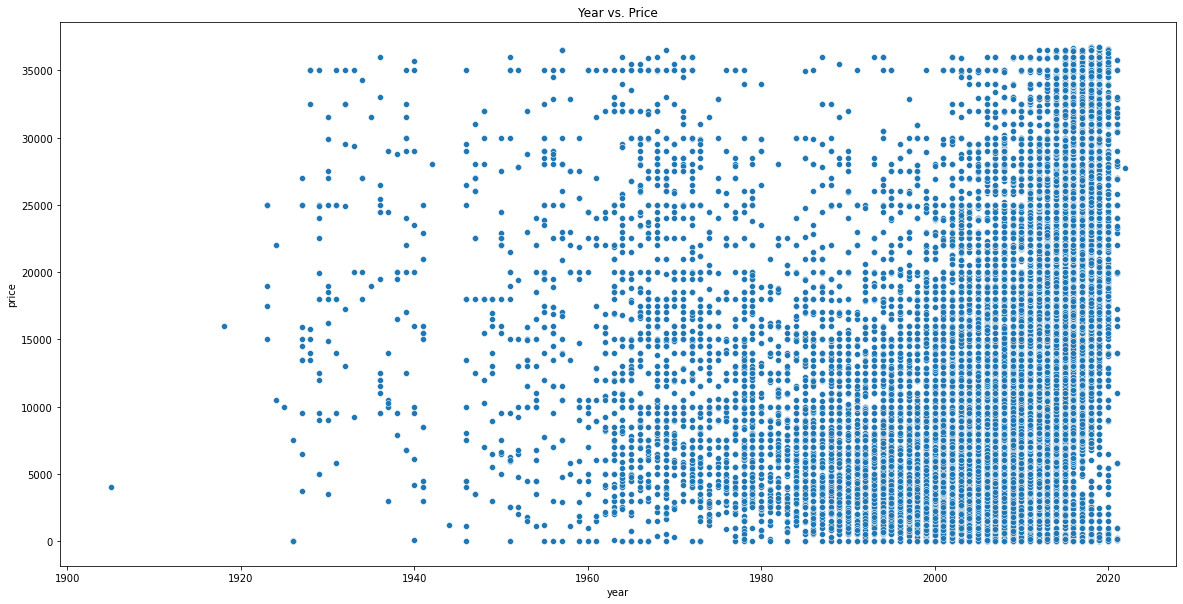

In [781]:
sns.scatterplot(data=dataf,x='year',y='price').set(title = 'Year vs. Price')
rcParams['figure.figsize'] = 20, 10

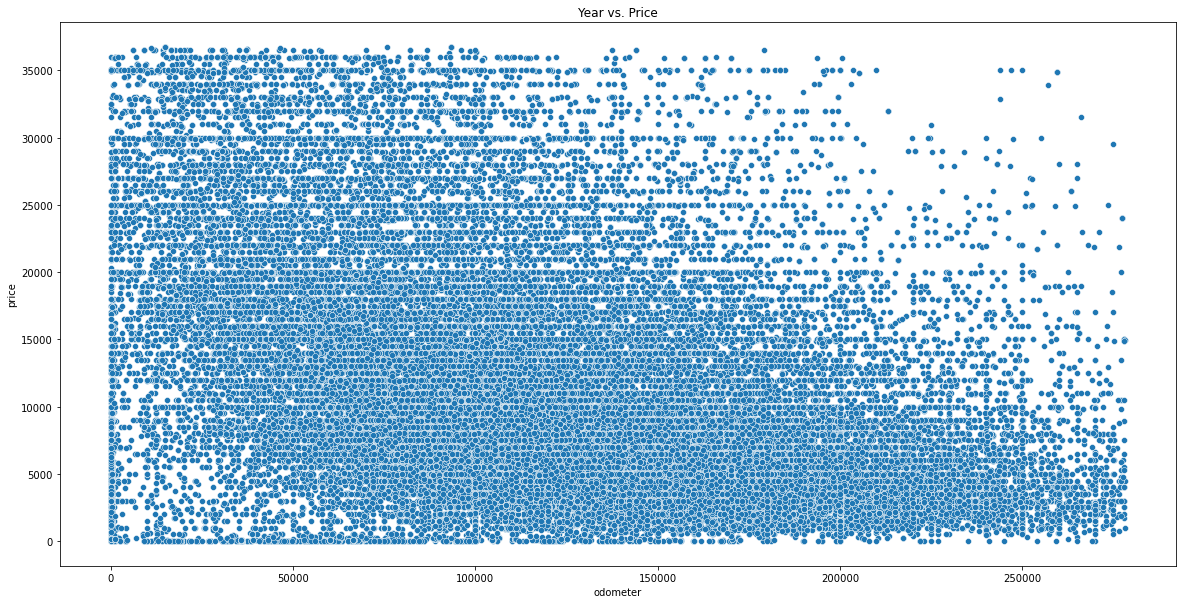

In [782]:
sns.scatterplot(data=dataf,x='odometer',y='price').set(title = 'Year vs. Price')
rcParams['figure.figsize'] = 20, 10

In [783]:
#Create list of values for one hot encoding:
encodelist = []
for i in onehotlist:
    for j in dataf[i].unique():
        encodelist.append(j)

#Ordinal features variable listed in order.
conditionlist = ['salvage','fair','good','excellent','like new','new']
sizelist = ['sub-compact','compact','mid-size','full-size']
titlelist = ['missing','salvage','parts only','lien','rebuilt','clean']



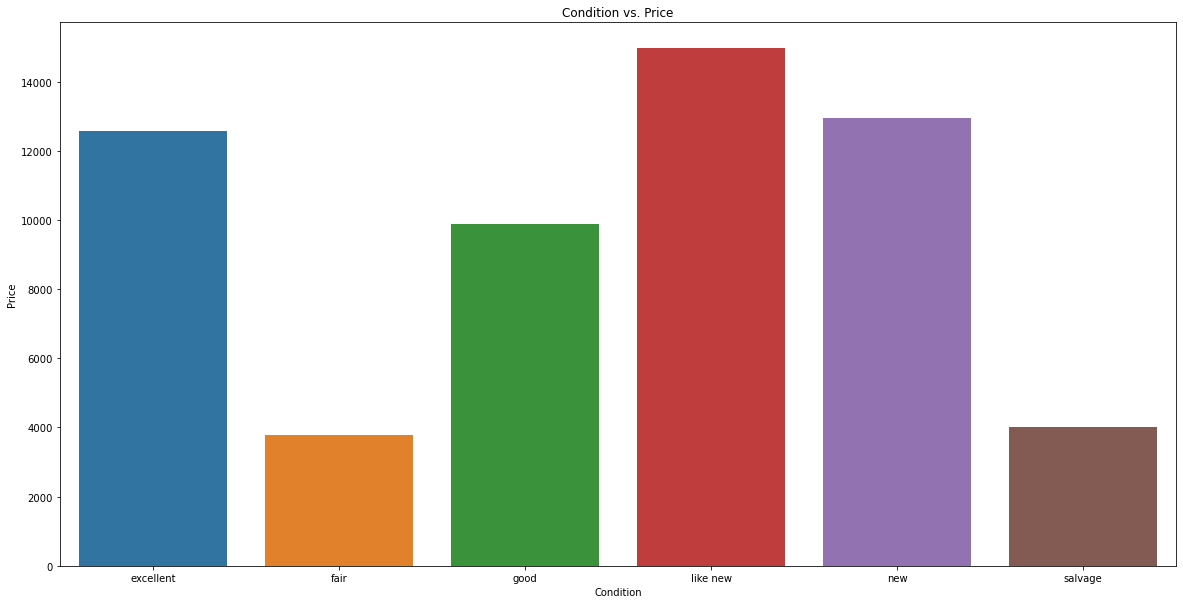

In [784]:
#Plot average prices by condition. There does appear to be somewhat of a pattern.
plot = sns.barplot(data = dataf.groupby('condition').mean(), x = dataf.groupby('condition').mean().index, y='price').set(title = 'Condition vs. Price',xlabel='Condition',ylabel='Price')

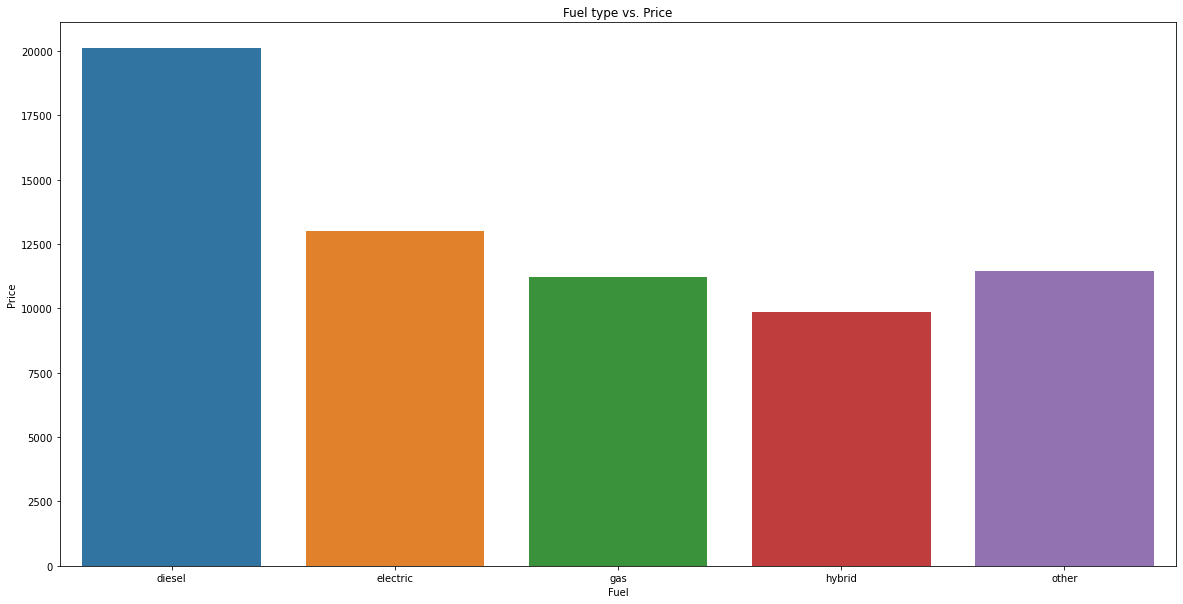

In [785]:
#Plot average prices by fuel type. There does appear to be somewhat of a pattern.
plot = sns.barplot(data = dataf.groupby('fuel').mean(), x = dataf.groupby('fuel').mean().index, y='price').set(title = 'Fuel type vs. Price',xlabel='Fuel',ylabel='Price')

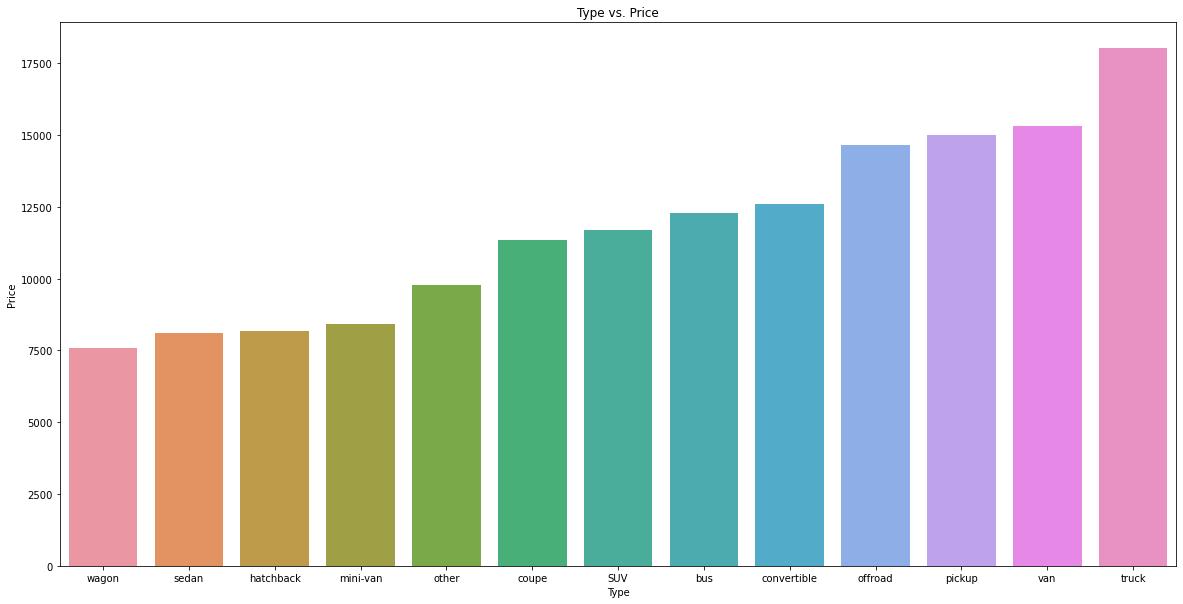

In [786]:
gtype = dataf.groupby('type').mean().sort_values(by='price')
#Plot average prices by condition. There does appear to be somewhat of a pattern.
plot = sns.barplot(data = gtype, x = gtype.index, y='price').set(title = 'Type vs. Price',xlabel='Type',ylabel='Price')

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

1. Test / Train split to make a test set for later verification of the model.
2. For parameters to explore, explore different polynomials of good variables (or all variables) and compare mses.

In [602]:
dataf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70303 entries, 7316356412 to 7302338378
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         70303 non-null  int64  
 1   year          70303 non-null  float64
 2   condition     70303 non-null  object 
 3   cylinders     70303 non-null  int64  
 4   fuel          70303 non-null  object 
 5   odometer      70303 non-null  float64
 6   title_status  70303 non-null  object 
 7   transmission  70303 non-null  object 
 8   drive         70303 non-null  object 
 9   size          70303 non-null  object 
 10  type          70303 non-null  object 
 11  paint_color   70303 non-null  object 
 12  VINBool       70303 non-null  int64  
dtypes: float64(2), int64(3), object(8)
memory usage: 7.5+ MB


#### Initial Linear Regression

In [787]:
#Split data into training and testing columns
train, test = train_test_split(dataf, test_size = 0.3,random_state=42)

X_train = train.drop('price',axis=1)
y_train = train['price']
X_test = test.drop('price',axis=1)
y_test = test['price']

#Test various feature degrees and collect mse values for training and testing.
msetrains = []
msetests = []
degrees = []
for i in range(1,11):
#Column transformer, polynomial degree of all numerical columns, onehotencoder for the categorical values that can't really be ordered, ordinalencoder for the columns that can be ordered somewhat.
    trans = make_column_transformer(
                                    (PolynomialFeatures(degree=i), make_column_selector(dtype_include=np.number)),
                                    (OneHotEncoder(drop='if_binary'), X_train[onehotlist].columns),
                                    (OrdinalEncoder(categories = [conditionlist]),X_train[['condition']].columns),
                                    (OrdinalEncoder(categories = [sizelist]),X_train[['size']].columns),
                                    (OrdinalEncoder(categories = [titlelist]),X_train[['title_status']].columns)
                                   )
    #Create pipeline to transform and model as linear regression
    pipe = Pipeline([
        ('one', trans),
        ('model', LinearRegression())
    ])
    #Fit model using training data
    pipe.fit(X_train,y_train)
    #Calculate mean squared errors
    msetrain = mean_squared_error(pipe.predict(X_train),y_train)
    msetest = mean_squared_error(pipe.predict(X_test),y_test)
    msetrains.append(msetrain)
    msetests.append(msetest)
    degrees.append(i)
 #   print('Training MSE: ' + str(msetrain) +'\nTest MSE: ' + str(msetest))

#### Graph MSE values to determine number of polynomial features to use, and visualize difference in MSE from training vs test data split.

[Text(0.5, 1.0, 'Mean Squared Error vs. Polynomial Degree'),
 Text(0.5, 0, 'Polynomial Degree'),
 Text(0, 0.5, 'MSE * 10 **7')]

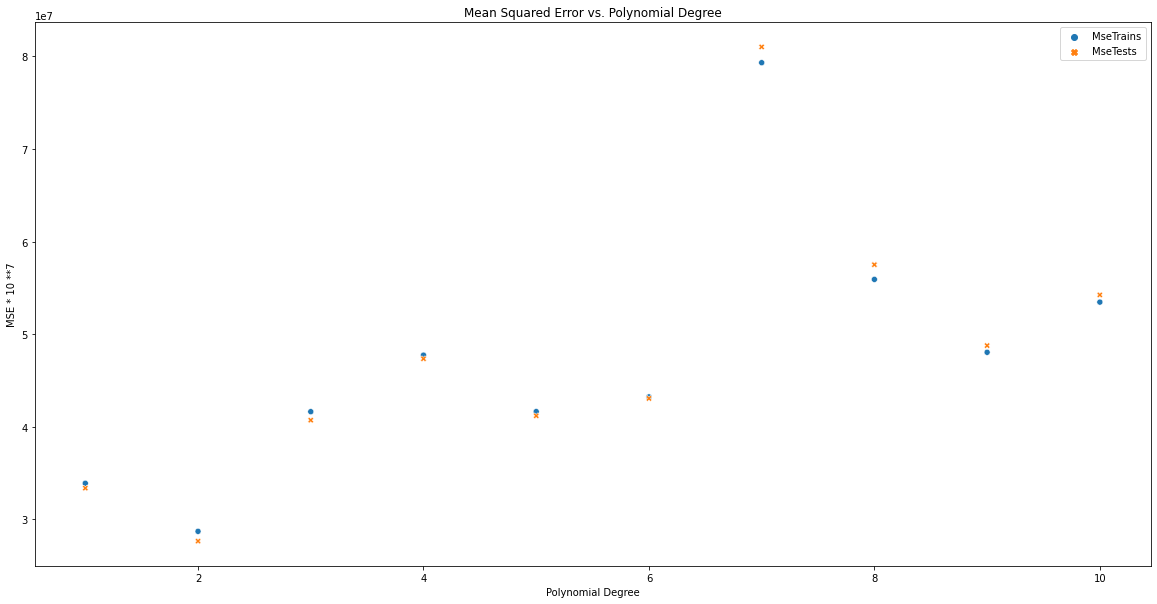

In [788]:
msedf = pd.DataFrame(msetrains,degrees)
msedf.columns = ['MseTrains']
msedf['MseTests'] = msetests
sns.scatterplot(data=msedf).set(title = 'Mean Squared Error vs. Polynomial Degree', xlabel = 'Polynomial Degree',ylabel = 'MSE * 10 **7')
#Looks like 2 degrees is the best, so will use that for model.
#When compared with test data, training MSEs not too far off, so doesn't seem to be overtrained

#### Model based on Plot

In [790]:
#Model with degree = 2
trans = make_column_transformer(
                                    (PolynomialFeatures(degree=2), make_column_selector(dtype_include=np.number)),
                                    (OneHotEncoder(drop='if_binary'), X_train[onehotlist].columns),
                                    (OrdinalEncoder(categories = [conditionlist]),X_train[['condition']].columns),
                                    (OrdinalEncoder(categories = [sizelist]),X_train[['size']].columns),
                                    (OrdinalEncoder(categories = [titlelist]),X_train[['title_status']].columns)
                                   )
    #Create pipeline to transform and model as linear regression
pipe = Pipeline([
    ('trans', trans),
    ('model', LinearRegression())
])
    #Fit model using training data
pipe.fit(X_train,y_train)
    #Calculate mean squared errors
msetrain = mean_squared_error(pipe.predict(X_train),y_train)
msetest = mean_squared_error(pipe.predict(X_test),y_test)

print('Training MSE: ' + str(msetrain) +'\nTest MSE: ' + str(msetest))

Training MSE: 28715264.440260157
Test MSE: 27666267.009535085


In [791]:
pipe.score(X_train,y_train)

0.5979558143495672

In [792]:
pipe.score(X_test,y_test)

0.6135707880473031

#### Backtrack and do ordinal encoding before pipeline due to lack of getfeaturenames function.

In [794]:
#Since can't get feature names from other pipeline due to 'Ordinal Encoding' not having that function...
#Ordinally encode before using pipeline to get feature names and corresponding coefficients.
datat = dataf.copy()
datat['condition'] = OrdinalEncoder(categories = [conditionlist]).fit_transform(datat[['condition']])
datat['size'] = OrdinalEncoder(categories = [sizelist]).fit_transform(datat[['size']])
datat['title_status'] = OrdinalEncoder(categories = [titlelist]).fit_transform(datat[['title_status']])
train, test = train_test_split(datat, test_size = 0.3,random_state=42)

X_traint = train.drop('price',axis=1)
y_traint = train['price']
X_testt = test.drop('price',axis=1)
y_testt = test['price']

#Model with degree = 2
trans = make_column_transformer(
                                    (PolynomialFeatures(degree=2), make_column_selector(dtype_include=np.number)),
                                    (OneHotEncoder(drop='if_binary'), X_traint[onehotlist].columns))
    #Create pipeline to transform and model as linear regression
pipe = Pipeline([
    ('trans', trans),
    ('model', LinearRegression())
])
    #Fit model using training data

pipe.fit(X_traint,y_traint)
    #Calculate mean squared errors
    
msetrain = mean_squared_error(pipe.predict(X_traint),y_traint)
msetest = mean_squared_error(pipe.predict(X_testt),y_testt)

In [795]:
pipe.score(X_traint,y_traint)

0.6142700100846283

In [796]:
pipe.score(X_testt,y_testt)

0.6269568826942271

### Somewhat of a mess, printed out corresponding names and their coefficients for later analysis

In [797]:
for i in range(0,len(pipe['trans'].get_feature_names_out())):
    print(pipe['trans'].get_feature_names_out()[i] +': '+ str(pipe['model'].coef_[i]))
    
#Shows coefficients and what features they correspond to. 

polynomialfeatures__1: 0.015101200211220505
polynomialfeatures__year: -39724.83527283702
polynomialfeatures__condition: 19650.78761274655
polynomialfeatures__cylinders: 25314.361871404733
polynomialfeatures__odometer: 1.7602849943432424
polynomialfeatures__title_status: -1135.384231691638
polynomialfeatures__size: -163541.2514382354
polynomialfeatures__VINBool: -56138.31564720935
polynomialfeatures__year^2: 10.012971489654047
polynomialfeatures__year condition: -8.58298937645668
polynomialfeatures__year cylinders: -12.904133342879959
polynomialfeatures__year odometer: -0.0008729415640118532
polynomialfeatures__year title_status: 0.5913649616482246
polynomialfeatures__year size: 81.01183597579939
polynomialfeatures__year VINBool: 55.44377283628728
polynomialfeatures__condition^2: -493.7203214255381
polynomialfeatures__condition cylinders: 320.65461476154303
polynomialfeatures__condition odometer: -0.0055017583654262125
polynomialfeatures__condition title_status: 126.57467306942634
polyn

#### Determine importance of each feature

In [799]:
r = permutation_importance(pipe,X_testt,y_testt,n_repeats=30)

In [800]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{pipe.feature_names_in_[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")
            
#Based on this linear regression model, most impactful features on price are year, odometer and type.
#Based on coefficeints, offroads are worth the most comparatively, followed by trucks etc. Year and odometer are more difficult to interpret due to being used in polynomial.
#For second model, only do year, odometer and type as they have the highest scores.

year    0.311 +/- 0.005
odometer0.199 +/- 0.003
type    0.116 +/- 0.003
fuel    0.062 +/- 0.002
cylinders0.061 +/- 0.002
drive   0.054 +/- 0.001
size    0.037 +/- 0.002
condition0.033 +/- 0.002
transmission0.030 +/- 0.001
VINBool 0.021 +/- 0.001
title_status0.004 +/- 0.000
paint_color0.002 +/- 0.000


#### Ridge model attempt, using highest scoring features from permutation importance in previous model

In [725]:
import warnings
warnings.filterwarnings('ignore')

In [816]:
dataridge = datat[['price','year','odometer','type','cylinders','fuel']]
train, test = train_test_split(dataridge, test_size = 0.3,random_state=42)
X_trainr = train.drop('price',axis=1)
y_trainr = train['price']
X_testr = test.drop('price',axis=1)
y_testr = test['price']
trans = make_column_transformer(
                                    (PolynomialFeatures(degree=2), make_column_selector(dtype_include=np.number)))

#Create pipeline to transform and model as Ridge

pipe = Pipeline([
    ('trans', trans),
    ('selector', SequentialFeatureSelector(Ridge())),
    ('ridge', Ridge(alpha = 10))
])
pipe.fit(X_trainr,y_trainr)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001BEBB150F10>)])),
                ('selector', SequentialFeatureSelector(estimator=Ridge())),
                ('ridge', Ridge(alpha=10))])

In [802]:
ridges = []
for i in range(0,11):
    ridges.append(i)

In [803]:
#GridSearchCV to determine best alpha value for ridge model
param_dict = {'ridge__alpha':ridges}
ridge_grid = GridSearchCV(pipe,param_dict)
ridge_grid.fit(X_trainr,y_trainr)

GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('polynomialfeatures',
                                                                         PolynomialFeatures(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001BEBB4326D0>)])),
                                       ('selector',
                                        SequentialFeatureSelector(estimator=Ridge())),
                                       ('ridge', Ridge(alpha=10))]),
             param_grid={'ridge__alpha': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [804]:
estimator = ridge_grid.best_estimator_
model=e.named_steps['ridge']
model
#Best alpha is 6, model accordingly.

Ridge(alpha=6)

In [817]:
pipe = Pipeline([
    ('trans', trans),
    ('selector', SequentialFeatureSelector(Ridge())),
    ('ridge', Ridge(alpha = 6))
])
pipe.fit(X_trainr,y_trainr)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001BEBB150F10>)])),
                ('selector', SequentialFeatureSelector(estimator=Ridge())),
                ('ridge', Ridge(alpha=6))])

In [818]:
msetrain = mean_squared_error(pipe.predict(X_trainr),y_trainr)
msetest = mean_squared_error(pipe.predict(X_testr),y_testr)
print('Training MSE: ' + str(msetrain) +'\nTest MSE: ' + str(msetest))
#These values are very high, but still close to one another. At least it doesn't appear to be overfit.

Training MSE: 42138925.16104852
Test MSE: 41592877.74463774


In [819]:
pipe.score(X_test,y_test)
#Very low score, check linear regression with these variables.

0.4190505367360974

#### Linear Regression again, with same features as ridge model. 

In [821]:
#Linear regression again, but with highest scored features. Scores still not very high.
datat = dataf[['price','year','odometer','type','cylinders','fuel']]
train, test = train_test_split(datat, test_size = 0.3,random_state=42)

X_traint = train.drop('price',axis=1)
y_traint = train['price']
X_testt = test.drop('price',axis=1)
y_testt = test['price']

#Model with degree = 1
trans = make_column_transformer(
                                    (PolynomialFeatures(degree=1), make_column_selector(dtype_include=np.number)))
    #Create pipeline to transform and model as linear regression
pipe = Pipeline([
    ('trans', trans),
    ('model', LinearRegression())
])
    #Fit model using training data

pipe.fit(X_traint,y_traint)
    #Calculate mean squared errors
    
msetrain = mean_squared_error(pipe.predict(X_traint),y_traint)
msetest = mean_squared_error(pipe.predict(X_testt),y_testt)

In [822]:
pipe.score(X_traint,y_traint)

0.3249771540143288

In [823]:
pipe.score(X_testt,y_testt)

0.33066301668983855

In [824]:
for i in range(0,len(pipe['trans'].get_feature_names_out())):
    print(pipe['trans'].get_feature_names_out()[i] +': '+ str(pipe['model'].coef_[i]))
    
#Shows coefficients and what features they correspond to. Based on this, generally it appears that as year increases, so does price and price decreases with odometer.


polynomialfeatures__1: 0.0
polynomialfeatures__year: 237.195818750653
polynomialfeatures__odometer: -0.062256397596911484
polynomialfeatures__cylinders: 1870.74067202202


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

I would idtentify a high quality model as one with a score relatively close to 1, relatively low mean squared errors and mean squared errors very similar between training and testing split data. As our business objective is to determine what features of used cars are attractive to customers based on price, my models aim to predict price based on the other columns in the dataset. Althouh my MSEs are still fairly high, the score for my linear regression model is above 0.6, and with similar MSE between training and test data, it does not appear to be overfitted. I belive that the results from permutation importance of that model should be accurate in implicating year, odometer and type of car as fairly influential in determining price.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

After modeling the dataset provided in attempts to determine what features of used cars contribute to price, the year, odometer and type of car appear to have the greatest impact on price, with cars in later years being worth more and cars with higher odometer values being worth less on average. As for type of car, cars such as trucks and offroad seem to be priced higher, while cars such as wagons are priced lower overall. As such, stocking up on newer vechicles with lower miles driven and picking up more trucks and offroad vechicles in favor of cars such as wagons could help with fine-tuning inventories. 

Further analysis of the data could be benfifical, however, as some features such as state or model of car have far too many categories to be analyzed through the methods I used and may have an impact on price as well. Next steps would be to analyze the larger categories while proceeding with these preliminary findings.